# Box Office Analysis

Authors: Greg Fatouras and Evan Rosenbaum

# Business Problem

Addressing Real-World Problems: Movie Database Analysis

Our project focuses on solving critical challenges faced by stakeholders in the film industry:

- Optimizing Release Days: For producers and distributors aiming to maximize box office returns, our analysis identifies optimal release days based on historical data, helping them schedule releases strategically.

- Identifying High-Rated Genres: By pinpointing genres consistently rated highest, filmmakers and streaming platforms can better cater to audience preferences and refine content strategies.

- Highlighting Key Contributors: We analyze the roles of writers, producers, studios, and actors in successful genres, aiding studios and casting agencies in making informed decisions about talent and collaboration.

Through data-driven insights, our project allows stakeholders to make more informed decisions, optimize resources, and enhance overall performance in the film production industry.

# Sources of Data 

- Box Office Mojo
    - CSV
    - https://www.boxofficemojo.com/
- IMDB
    - DB
    - https://www.imdb.com/
- Rotten Tomatoes
    - TSVs
    - https://www.rottentomatoes.com/
- The Movie DB
    - CSV
    - https://www.themoviedb.org/
- The Numbers
    - CSV
    - https://www.the-numbers.com/

# Data Exploration

In [1]:
# Import packages
import sqlite3
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## IMDB DB extraction

In [2]:
# Extract db from zipped file
zip_path = 'zippedData/im.db.zip'
extract_dir = 'zippedData'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
# Connect to SQLite3
conn = sqlite3.connect('zippedData/im.db') 
cursor = conn.cursor()

# View tables query
tables_query = """
SELECT *
FROM sqlite_master
WHERE type='table'
"""

pd.read_sql(tables_query, conn)

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [4]:
# List each table
table_names = [
    'movie_basics'
    ,'directors'
    ,'known_for'
    ,'movie_akas'
    ,'movie_ratings'
    ,'persons'
    ,'principals'
    ,'writers'
]

# Extract the columns from each table in the database
for table in table_names:
    headers_query = f"SELECT * FROM {table}"
    df = pd.read_sql(headers_query, conn)
    print(f"\nHeader for {table}:")
    print(df.columns.to_list())



Header for movie_basics:
['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']

Header for directors:
['movie_id', 'person_id']

Header for known_for:
['person_id', 'movie_id']

Header for movie_akas:
['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']

Header for movie_ratings:
['movie_id', 'averagerating', 'numvotes']

Header for persons:
['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']

Header for principals:
['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']

Header for writers:
['movie_id', 'person_id']


In [5]:
imdb_cast_info_query = """

with movie_info AS (
SELECT *
FROM movie_basics
WHERE start_year > 2000
),

cast_info AS (
SELECT
    *
FROM principals
INNER JOIN persons
ON principals.person_id = persons.person_id
),

movie_rating AS (
SELECT *
FROM movie_ratings
),

us_movies AS (
SELECT * 
FROM movie_akas
WHERE region = 'US'
AND region IS NOT NULL
)

SELECT
    movie_info.movie_id
    ,primary_title AS title
    ,start_year AS year
    ,COALESCE(CAST(runtime_minutes AS text), 'unknown') AS runtime_minutes
    ,COALESCE(genres, 'unknown') AS genres
    ,category AS cast_category
    ,primary_name AS cast_name
    ,averagerating
    ,numvotes
FROM movie_info
INNER JOIN us_movies 
ON movie_info.movie_id = us_movies.movie_id
INNER JOIN cast_info
ON movie_info.movie_id = cast_info.movie_id
LEFT JOIN movie_rating
ON movie_info.movie_id = movie_rating.movie_id

"""
imdb_cast_info_df = pd.read_sql(imdb_cast_info_query, conn)

In [6]:
imdb_movie_rating_query = """

with movie_info AS (
SELECT *
FROM movie_basics
WHERE start_year > 2000
),

movie_rating AS (
SELECT *
FROM movie_ratings
),

us_movies AS (
SELECT * 
FROM movie_akas
WHERE region = 'US'
)

SELECT
    movie_info.movie_id
    ,primary_title AS title
    ,start_year AS year
    ,COALESCE(CAST(runtime_minutes AS text), 'unknown') AS runtime_minutes
    ,COALESCE(genres, 'unknown') AS genres
    ,averagerating
    ,numvotes
FROM movie_info
INNER JOIN us_movies 
ON movie_info.movie_id = us_movies.movie_id
LEFT JOIN movie_rating
ON movie_info.movie_id = movie_rating.movie_id

"""
imdb_movie_rating_df = pd.read_sql(imdb_movie_rating_query, conn)

## CSV and TSV extractions

Moving forward the name of each data source will be:

- Box Office Mojo -> bom
- IMDB -> imdb
- Rotten Tomatoes -> rot
- The Movie DB -> tmdb
- The Numbers -> tn

In [7]:
# Load all other dataframes and view columns
bom_df = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', encoding='latin1', delimiter='\t')
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', encoding='latin1', delimiter='\t')
tmdb_df = pd.read_csv('zippedData/tmdb.movies.csv.gz')
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', encoding='utf-8')

dfs = [bom_df ,rt_movie_info_df ,rt_reviews_df ,tmdb_df ,tn_df]
dfs_str = ['bom_df' ,'rt_movie_info_df' ,'rt_reviews_df' ,'tmdb_df' ,'tn_df']

for x in range(len(dfs)):
    print(dfs_str[x])
    print(dfs[x].columns)
    print("\n")

bom_df
Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


rt_movie_info_df
Index(['id', 'synopsis', 'rating', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio'],
      dtype='object')


rt_reviews_df
Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date'],
      dtype='object')


tmdb_df
Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')


tn_df
Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')




### Box Office Mojo Exploration

In [8]:
# View high-level information about the DataFrame
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


#### Studio column

In [9]:
# View NaNs in the 'studio' column
bom_df[bom_df['studio'].isna()]

,title,studio,domestic_gross,foreign_gross,year
210,Outside the Law (Hors-la-loi),NaN,96900.0,3300000,2010
555,Fireflies in the Garden,NaN,70600.0,3300000,2011
933,Keith Lemon: The Film,NaN,NaN,4000000,2012
1862,Plot for Peace,NaN,7100.0,NaN,2014
2825,Secret Superstar,NaN,NaN,122000000,2017


- It isn't clear as to why the studios for these films are not included inside of the BOM csv. 

#### Domestic and Foreign Gross columns

In [10]:
# View NaNs in the 'foreign_gross' column
bom_df[bom_df['foreign_gross'].isna()].head()

,title,studio,domestic_gross,foreign_gross,year
222,Flipped,WB,1800000.0,NaN,2010
254,The Polar Express (IMAX re-issue 2010),WB,673000.0,NaN,2010
267,Tiny Furniture,IFC,392000.0,NaN,2010
269,Grease (Sing-a-Long re-issue),Par.,366000.0,NaN,2010
280,Last Train Home,Zeit.,288000.0,NaN,2010


- NaN values inside of these column indicate that there was no revenue generated from either a domestic or international release. The movie might have had a subsequent releases either domestic or international post their initial release, but the revenue from that is not captured inside of the row as it occurred in a different year. 
- Example:
    - Flipped (2010)
        - https://www.boxofficemojo.com/title/tt0817177/?ref_=bo_se_r_1
        - The films original release had no international revenue generated, but upon further releases in 2017 and 2020 there was.
        - That said, since the revenue was generated in a different year, it is not tied to the record in question. 

### Rotten Tomatoes Exploration

In [11]:
rt_combined_df = rt_movie_info_df.merge(rt_reviews_df, how='inner', on='id', suffixes=('_info', '_review'))

In [12]:
rt_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             54432 non-null  int64 
 1   synopsis       54300 non-null  object
 2   rating_info    54346 non-null  object
 3   genre          54345 non-null  object
 4   director       48992 non-null  object
 5   writer         45206 non-null  object
 6   theater_date   53206 non-null  object
 7   dvd_date       53206 non-null  object
 8   currency       33310 non-null  object
 9   box_office     33310 non-null  object
 10  runtime        53594 non-null  object
 11  studio         40125 non-null  object
 12  review         48869 non-null  object
 13  rating_review  40915 non-null  object
 14  fresh          54432 non-null  object
 15  critic         51710 non-null  object
 16  top_critic     54432 non-null  int64 
 17  publisher      54123 non-null  object
 18  date           54432 non-n

- There is missingness inside of the DataFrame however, as we move forward we will drop the NaNs in the columns we are looking at. 

### The Movie DB Exploration

In [13]:
# View high-level information about the DataFrame
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [14]:
# View DataFrame results
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


- There are no NaN values inside of the DataFrame so no actions are needed to ensure missingness is handled. 
- genre_ids
    - https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee
    - We can map the ids to be the specific genres rather than the id (if needed)


### The Numbers Exploration

In [15]:
# View high-level information about the DataFrame
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [16]:
# View DataFrame results
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


- There are no NaN values inside of the DataFrame so no actions are needed to ensure missingness is handled. 

### IMDB DB Exploration

In [17]:
# View DataFrame
imdb_cast_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388634 entries, 0 to 388633
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         388634 non-null  object 
 1   title            388634 non-null  object 
 2   year             388634 non-null  int64  
 3   runtime_minutes  388634 non-null  object 
 4   genres           388634 non-null  object 
 5   cast_category    388634 non-null  object 
 6   cast_name        388634 non-null  object 
 7   averagerating    264280 non-null  float64
 8   numvotes         264280 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 26.7+ MB


In [18]:
# View DataFrame
imdb_movie_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         51490 non-null  object 
 1   title            51490 non-null  object 
 2   year             51490 non-null  int64  
 3   runtime_minutes  51490 non-null  object 
 4   genres           51490 non-null  object 
 5   averagerating    30194 non-null  float64
 6   numvotes         30194 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 2.7+ MB


### Notes

There is a lot of crossover between the Box Office Mojo DataFrame and The Numbers DataFrame. Since The Numbers DataFrame is larger, more exact, and contains movie titles from Box Office Mojo, we are going to use The Numbers moving forward and no longer use the Box Office Mojo csv information.

# Initial Dataframe Lengths

In [19]:
print('Initial Lengths:')
print("IMDB cast info:",'{:>10}'.format(len(imdb_cast_info_df)))
print("IMDB movie rating:",'{:>6}'.format(len(imdb_movie_rating_df)))
print("TN:",'{:>20}'.format(len(tn_df)))
print("TMDB:",'{:>19}'.format(len(tmdb_df)))
print("RT movie info:",'{:>9}'.format(len(rt_movie_info_df)))
print("BOM:",'{:>19}'.format(len(bom_df)))

Initial Lengths:
IMDB cast info:     388634
IMDB movie rating:  51490
TN:                 5782
TMDB:               26517
RT movie info:      1560
BOM:                3387


# Dataframe Cleaning

## The Movie DB
- Removed duplicate id values since this is the most important key for differentating movies. 
- Dropped "original_title" since this column contains movie titles in their foreign languages.
- Created day, month, year, and day of week columns for date analysis.
- Created a TMDB code dictionary for matching numerical genre codes to the strings.

In [20]:
# Drop duplicate ID's
tmdb_df = tmdb_df.drop_duplicates(subset=['id'])

In [21]:
# Find differing titles
different = tmdb_df['original_title'] != tmdb_df['title']

In [22]:
# Filter the DataFrame 
differences = tmdb_df[different]
# 'Original title' contains foreign language titles
#differences

In [23]:
# Dropping 'original title' because it's in the foreign language
tmdb_df = tmdb_df.drop('original_title', axis = 1) 

In [24]:
# Sort by date
tmdb_df = tmdb_df.sort_values(by = 'release_date', ascending = False)

In [25]:
# Adding year, month, day, and day of week
tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'], format="%Y-%m-%d")

In [26]:
# Adding genre codes
tmdb_codes = [
    {"id": 28, "genre": "Action", "type": "MOVIE"},
    {"id": 12, "genre": "Adventure", "type": "MOVIE"},
    {"id": 16, "genre": "Animation", "type": "MOVIE"},
    {"id": 35, "genre": "Comedy", "type": "MOVIE"},
    {"id": 80, "genre": "Crime", "type": "MOVIE"},
    {"id": 99, "genre": "Documentary", "type": "MOVIE"},
    {"id": 18, "genre": "Drama", "type": "MOVIE"},
    {"id": 10751, "genre": "Family", "type": "MOVIE"},
    {"id": 14, "genre": "Fantasy", "type": "MOVIE"},
    {"id": 36, "genre": "History", "type": "MOVIE"},
    {"id": 27, "genre": "Horror", "type": "MOVIE"},
    {"id": 10402, "genre": "Music", "type": "MOVIE"},
    {"id": 9648, "genre": "Mystery", "type": "MOVIE"},
    {"id": 10749, "genre": "Romance", "type": "MOVIE"},
    {"id": 878, "genre": "Science Fiction", "type": "MOVIE"},
    {"id": 10770, "genre": "TV Movie", "type": "MOVIE"},
    {"id": 53, "genre": "Thriller", "type": "MOVIE"},
    {"id": 10752, "genre": "War", "type": "MOVIE"},
    {"id": 37, "genre": "Western", "type": "MOVIE"}

]

In [27]:
# Taking the first genre if multible genres are listed

tmdb_df = tmdb_df[tmdb_df["genre_ids"] != "[]"]

genre = []

for temp in tmdb_df['genre_ids']:
    temp = temp.strip()
    temp = temp.lstrip('[')
    temp = temp.split(']')[0]

    genre.append(temp.split(',')[0])

tmdb_df['genre_ids'] = genre

# Creating movie/show, genere columns
genre_str = []

for item in tmdb_df['genre_ids']:

    for value in tmdb_codes:

        if item == str(value['id']):
            genre_str.append(value['genre'])
            break
        
tmdb_df['genre_str'] = genre_str

In [28]:
# Extract month, day, and year
tmdb_df['month'] = tmdb_df['release_date'].dt.month
tmdb_df['day'] = tmdb_df['release_date'].dt.day
tmdb_df['year'] = tmdb_df['release_date'].dt.year
tmdb_df['day_of_week'] = tmdb_df['release_date'].dt.day_name()

# Everything after 2000
tmdb_df = tmdb_df[tmdb_df['year'] > 2000]
tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,popularity,release_date,title,vote_average,vote_count,genre_str,month,day,year,day_of_week
26057,26057,27,570704,en,0.840,2020-12-25,Murdery Christmas,0.0,1,Horror,12,25,2020,Friday
24265,24265,10749,428836,en,8.715,2019-06-28,Ophelia,0.0,4,Romance,6,28,2019,Friday
24892,24892,99,541577,en,3.955,2019-06-28,This Changes Everything,0.0,1,Documentary,6,28,2019,Friday
24297,24297,18,415085,en,8.316,2019-05-17,All Creatures Here Below,5.0,5,Drama,5,17,2019,Friday
24819,24819,18,481880,en,4.480,2019-05-17,Trial by Fire,7.0,3,Drama,5,17,2019,Friday


## The Numbers
* Sorted the movies by release date, and only kept the first occurrence of each movie.
    + The dataframe has no unique id column, so the movie titles will be the most important key.
- Any movie titles with scrambled ASCII values were removed.
- Removed any NaN profits/budgets.
- Converted currency values to intergers.
- Created day, month, year, and day of week columns for date analysis.
- Created net gross values for each movie

In [29]:
# Sort by date
tn_df = tn_df.sort_values(by = 'release_date', ascending = False)

In [30]:
# Keep the first duplicated value, drop the rest
tn_df = tn_df.drop_duplicates(subset='movie', keep='first')

In [31]:
# Remove any titles that do not start with a normal char
tn_df = tn_df[tn_df['movie'].str.match(r'^[A-Za-z]')]

In [32]:
# Removing rows with 0 gross/net values
tn_df = tn_df[(tn_df['production_budget'] != '$0') & (tn_df['domestic_gross'] != '$0') & (tn_df['worldwide_gross'] != '$0')]

In [33]:
# Converting money values to int, and find net profit
tn_df['production_budget'] = tn_df['production_budget'].str.replace('$', '').str.replace(',', '')
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].str.replace('$', '').str.replace(',', '')
tn_df['domestic_gross'] = tn_df['domestic_gross'].str.replace('$', '').str.replace(',', '')

tn_df['production_budget'] = pd.to_numeric(tn_df['production_budget'])
tn_df['worldwide_gross'] = pd.to_numeric(tn_df['worldwide_gross'])
tn_df['domestic_gross'] = pd.to_numeric(tn_df['domestic_gross'])

tn_df['domestic_net'] = tn_df['domestic_gross'] - tn_df['production_budget']
tn_df['worldwide_net'] = tn_df['worldwide_gross'] - tn_df['production_budget']

In [34]:
# Adding year, month, day, and day of week
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'], format="%b %d, %Y")

# Extract month, day, and year
tn_df['month'] = tn_df['release_date'].dt.month
tn_df['day'] = tn_df['release_date'].dt.day
tn_df['year'] = tn_df['release_date'].dt.year
tn_df['day_of_week'] = tn_df['release_date'].dt.day_name()

In [35]:
# No values prior to 2000
tn_df = tn_df[tn_df['year'] > 2000]
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domestic_net,worldwide_net,month,day,year,day_of_week
3712,13,2016-09-09,Kicks,10000000,150191,150191,-9849809,-9849809,9,9,2016,Friday
3584,85,2016-09-09,When the Bough Breaks,10000000,29747603,30768449,19747603,20768449,9,9,2016,Friday
3129,30,2016-09-09,The Disappointments Room,15000000,2423467,3503761,-12576533,-11496239,9,9,2016,Friday
3287,88,2016-09-09,Robinson Crusoe,13000000,8005586,42446455,-4994414,29446455,9,9,2016,Friday
849,50,2016-09-09,Sully,60000000,125070033,238524556,65070033,178524556,9,9,2016,Friday


## IMDB 

- There are some missing averagerating or numvotes values in the dataframe. 
- Since we are using these columns to determine whether the movie performed successfully, we will drop the rows where there are no values in these columns.

In [36]:
# Drop NaNs
imdb_cast_info_df.dropna(inplace=True)
imdb_movie_rating_df.dropna(inplace=True)

# Drop any duplicates
imdb_cast_info_df.drop_duplicates(inplace=True)
imdb_movie_rating_df.drop_duplicates(inplace=True)

### Number of Votes 

We will want to investigate the range of the number of votes cast for each film to determine what a meaningful number of votes cast would be.

If we compare a film has a 10.0 rating with 5 votes cast to a film that has a 9.5 rating with 5000 votes cast, we trust the later number more. 

#### IMDB Movie Rating Analysis

In [37]:
# Calculate statistics
min_votes = imdb_movie_rating_df['numvotes'].min()
max_votes = imdb_movie_rating_df['numvotes'].max()
mean_votes = imdb_movie_rating_df['numvotes'].mean()
median_votes = imdb_movie_rating_df['numvotes'].median()

print(f"Minimum number of votes: {min_votes}")
print(f"Maximum number of votes: {max_votes}")
print(f"Mean number of votes: {mean_votes}")
print(f"Median number of votes: {median_votes}")

Minimum number of votes: 5.0
Maximum number of votes: 1841066.0
Mean number of votes: 8405.710850153822
Median number of votes: 65.0


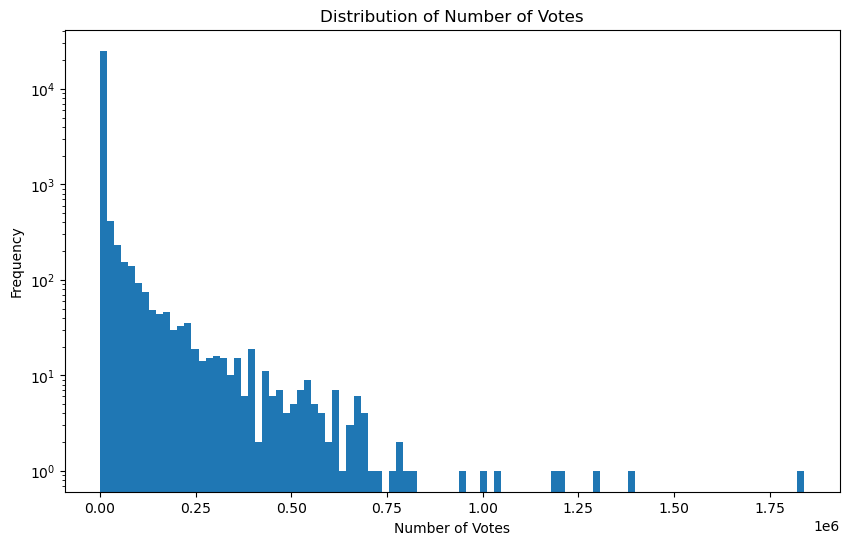

In [38]:
# View the distribution of votes
plt.figure(figsize=(10,6))

# Using log scale due to the wide range of values
plt.hist(imdb_movie_rating_df['numvotes'], bins=100, log=True)

plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Votes')
plt.show()

Since the distribution of votes is not normal distributed and it is heavily skewed to the right, we should use percentiles to determine which number of votes is signficant. 

Percentiles help us understand the spread and central tendency of the data without being overly influenced by extreme values.

They allow us to set thresholds based on the data's distribution. Using the 75th percentile means we are focusing on the top 25% of films by the number of votes, which likely represent more significant, widely-reviewed films.

This measure is more meaningful than using an arbitrary threshold because it is tailored to the data's distribution.

In [39]:
# Calculate the 75th and 90th percentiles
percentile_75 = imdb_movie_rating_df['numvotes'].quantile(0.75)
percentile_90 = imdb_movie_rating_df['numvotes'].quantile(0.90)

print(f"75th percentile of votes: {percentile_75}")
print(f"90th percentile of votes: {percentile_90}")

75th percentile of votes: 526.75
90th percentile of votes: 5445.600000000006


In [40]:
# Set the threshold using the 75th percentile
threshold = percentile_75

# Filter the DataFrame to include only movies with numvotes at or above the threshold
imdb_significant_movie_votes_df = imdb_movie_rating_df[imdb_movie_rating_df['numvotes'] >= threshold]

#### IMDB Cast Info Analysis

In [41]:
# Calculate the 75th percentile
percentile_75 = imdb_cast_info_df['numvotes'].quantile(0.75)

# Set the threshold using the 75th percentile
threshold = percentile_75

# Filter the DataFrame to include only movies with numvotes at or above the threshold
imdb_cast_info_df = imdb_cast_info_df[imdb_cast_info_df['numvotes'] >= threshold]

## Rotten Tomatoes

We want to see what the rating_review for each film as this our success metric. If there is a NaN in this column we will drop the row. 

In [42]:
# Drop rows 
rt_combined_df = rt_combined_df.dropna(subset=['rating_review'])

### Ratings

In [43]:
rt_combined_df['rating_review'].value_counts()

rating_review
3/5       4327
4/5       3672
3/4       3577
2/5       3160
2/4       2712
          ... 
3.1/5        1
6.2/10       1
2.6/5        1
9.7          1
3 1/2        1
Name: count, Length: 186, dtype: int64

There is no uniform way that the rating system has been handled. As such we will do some mappings to ensure that it is uniform. 

Keeping with their out of 10 rating system, we will transform the ratings so that they are all single values out of 10 points.

In [44]:
# Mapping letter grades to 0-10 scale
letter_grades = {
    'A+': 10, 'A': 9.5, 'A-': 9,
    'B+': 8.5, 'B': 8, 'B-': 7.5,
    'C+': 7, 'C': 6.5, 'C-': 6,
    'D+': 5.5, 'D': 5, 'D-': 4.5,
    'F+': 4, 'F': 3, 'F-': 2,
    'R': 0, 'N': 0, 'T': 0
}

def normalize_ratings(rating):
    if rating == '3 1/2':
        return 3.5
    elif rating == '1-5':
        return 2
    elif '/' in rating:
        num, denom = map(float, rating.split('/'))
        if num > denom:
            return 10.0
        else:
            return (num/denom) * 10
    elif rating in letter_grades:
        return letter_grades[rating]
    else:
        return rating

In [45]:
# Apply the cleaning function
rt_combined_df['rating_review'] = rt_combined_df['rating_review'].apply(normalize_ratings)

In [46]:
# Convert to floats
rt_combined_df['rating_review'] = pd.to_numeric(rt_combined_df['rating_review'])

# Round the floats to the 1st decimal place
rt_combined_df['rating_review'] = rt_combined_df['rating_review'].round(1)

- Since we are using ratings as the metric to determine success we want to ensure the rating is of high quality. As such, we will drop any review that is not from a top critic. 
- Additionally, since we want to see recent results at the theater, we will only be using films released after 2000.

### Dates and Review Quality

In [47]:
# Convert to DateTime
rt_combined_df['theater_date'] = pd.to_datetime(rt_combined_df['theater_date'])
rt_combined_df['dvd_date'] = pd.to_datetime(rt_combined_df['dvd_date'])
rt_combined_df['date'] = pd.to_datetime(rt_combined_df['date'])

# Filter so its inclusive of films after 2000
rt_combined_df = rt_combined_df[rt_combined_df['theater_date'] >= '2000-01-01']

# Filter reviews so they are only from top critics
rt_combined_df = rt_combined_df[(rt_combined_df['top_critic'] == 1)]

# High Level ROI

## The Numbers

In [48]:
# Sort by date and worldwide_gross
tn_date_profits_sorted = tn_df.sort_values(by= ["release_date","worldwide_net"], ascending = False)

# Keeping only the highest net for each date
tn_date_profits_sorted_uniq = tn_date_profits_sorted = tn_date_profits_sorted.drop_duplicates(subset='release_date', keep='first')

# Everything after 2000
tn_date_profits_sorted_uniq_2000 = tn_date_profits_sorted_uniq[tn_date_profits_sorted_uniq["year"] > 2000]

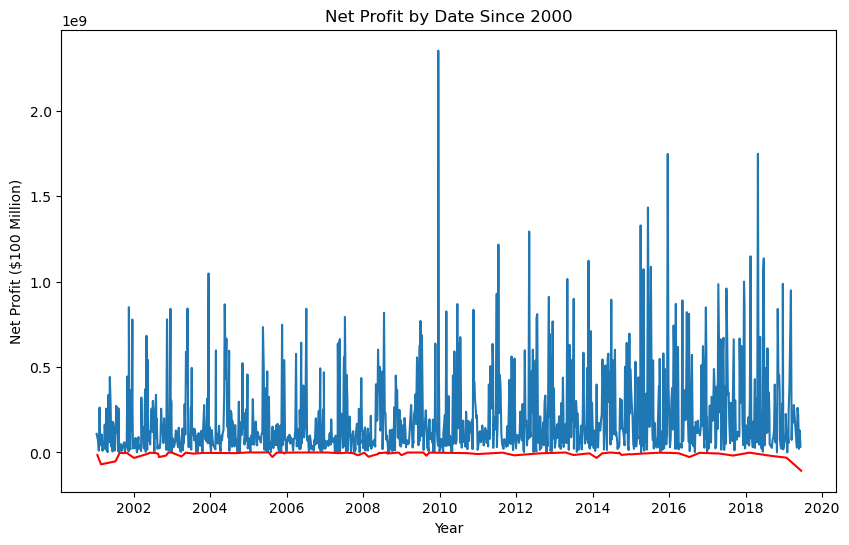

In [49]:
# Aggregate
net_gain_by_date = tn_date_profits_sorted_uniq_2000.groupby(['release_date'])['worldwide_net'].sum().reset_index()

# All gains after 2000
net_gain_by_date_gain = net_gain_by_date[net_gain_by_date["worldwide_net"] > 0]

# All losses after 2000
net_gain_by_date_loss = net_gain_by_date[net_gain_by_date["worldwide_net"] <= 0]


plt.figure(figsize=(10, 6))
plt.title("Net Profit by Date Since 2000")
plt.xlabel("Year")
plt.ylabel("Net Profit ($100 Million)")
plt.plot(net_gain_by_date_gain['release_date'],net_gain_by_date_gain['worldwide_net'])
plt.plot(net_gain_by_date_loss['release_date'],net_gain_by_date_loss['worldwide_net'],color = "red")
plt.show();

### Profit vs. release month
- Below we will be analyzing worldwide net profits by month to see if there is any variance.
- We found that there are significantly higher profits when a movie is released during the summer or winter months.

Top 5 months earned 65.3 % of all profits


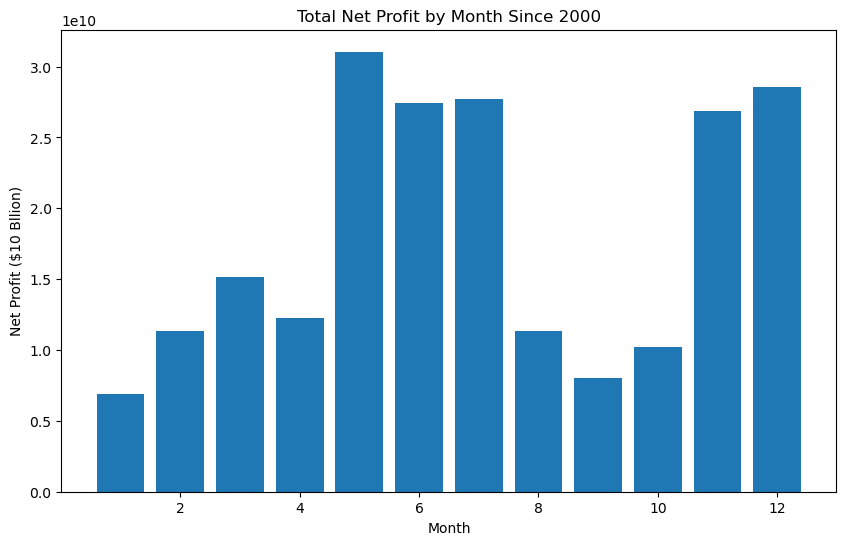

In [50]:
net_gain_by_month = tn_date_profits_sorted_uniq_2000.groupby(['month'])['worldwide_net'].sum().reset_index()
plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Month Since 2000")
plt.xlabel("Month")
plt.ylabel("Net Profit ($10 Bllion)")
plt.bar(net_gain_by_month['month'],net_gain_by_month['worldwide_net'])
top_5_months = (net_gain_by_month['worldwide_net'][4] + net_gain_by_month['worldwide_net'][5] + net_gain_by_month['worldwide_net'][6] + net_gain_by_month['worldwide_net'][10] + net_gain_by_month['worldwide_net'][11])
print("Top 5 months earned",round(top_5_months / net_gain_by_month['worldwide_net'].sum()*100,2),"% of all profits")

### Profit vs. release day
- Below we will be analyzing worldwide net profits by day to see if there is any variance within a month.
- We found that there seems to be a slight downwards trend in profit as the movie is released later in the month, with a slight peak in the middle. 

<BarContainer object of 31 artists>

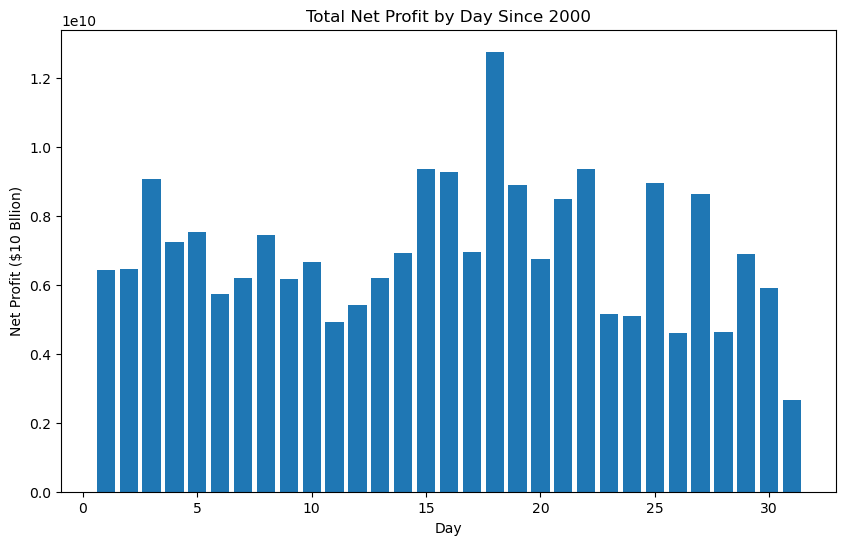

In [51]:
net_gain_by_day = tn_date_profits_sorted_uniq_2000.groupby(['day'])['worldwide_net'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Day Since 2000")
plt.xlabel("Day")
plt.ylabel("Net Profit ($10 Bllion)")
plt.bar(net_gain_by_day['day'],net_gain_by_day['worldwide_net'])

### Profits vs. release day of week
- Below we will be analyzing worldwide net profits by day of the week to see if there is any variance.
- We found that a movie releasing on a Friday will have significantly higher profits than any other day. 

Movies released on a friday saw 80.71 % of total profit


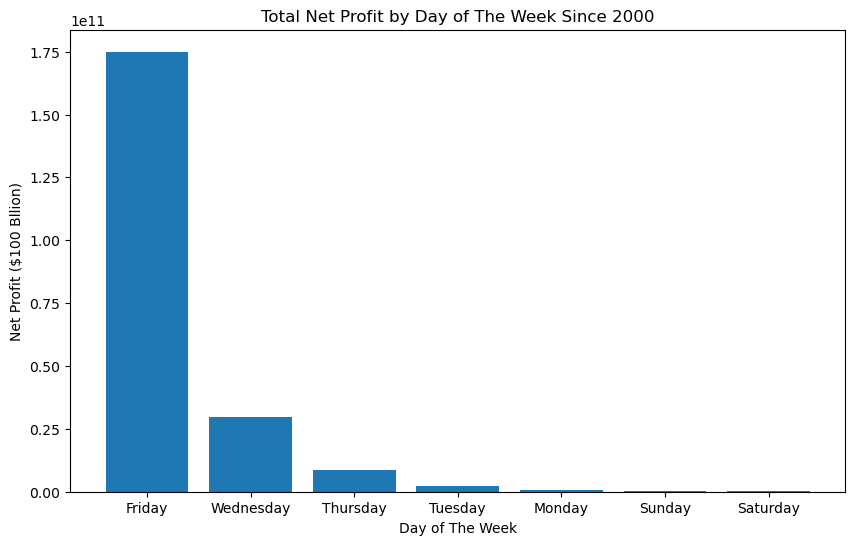

In [52]:
net_gain_by_dayof = tn_date_profits_sorted_uniq_2000.groupby(['day_of_week'])['worldwide_net'].sum().reset_index()
net_gain_by_dayof = net_gain_by_dayof.sort_values(by= 'worldwide_net', ascending= False)
plt.figure(figsize=(10, 6))
plt.title("Total Net Profit by Day of The Week Since 2000")
plt.xlabel("Day of The Week")
plt.ylabel("Net Profit ($100 Bllion)")
plt.bar(net_gain_by_dayof['day_of_week'],net_gain_by_dayof['worldwide_net'])
print("Movies released on a friday saw",round(net_gain_by_dayof['worldwide_net'][0] / net_gain_by_dayof['worldwide_net'].sum()*100,2),"% of total profit")

## Genre Analysis

In order to give a thorough recommendation on a film, we need to find which genre of film our client should pursue. 

We will do so by aggregating the information given in all three DataFrames where there is genre information. 

### The Movie DB

In [53]:
# Average movie rating by genre
tmdb_movie_rating = tmdb_df[['genre_str','vote_average', 'vote_count']]
tmdb_movie_rating = tmdb_movie_rating.groupby('genre_str').agg(
    average_rating=('vote_average', 'mean'),
    vote_count=('vote_count', 'size')
).reset_index()

tmdb_movie_rating = tmdb_movie_rating.sort_values(by='average_rating',ascending=False)

### Rotten Tomatoes

In [54]:
# Drop NaNs
rt_combined_df.dropna(subset=['genre'], inplace=True)

In [55]:
# Function to find valid main and sub genres
def find_valid_genres(genres):
    """
    Filters a list of genres to exclude specific categories and identify main and sub-genres.

    This function filters out genres listed as "Art House and International" and "Classics"
    from the input list and identifies the main genre and, if available, a sub-genre.

    Input:
    genres: A list of genre names.

    Output:
    tuple: A tuple containing the main genre and optionally the sub-genre:
        - main_genre (str): The first valid genre found in the list after filtering.
        - sub_genre (str or None): The second valid genre found, if present, otherwise None.

    If no valid genres are found after filtering, the function returns the first genre 
    from the original list as main_genre and None as sub_genre.
    """
    valid_genres = [genre for genre in genres if genre not in ["Art House and International", "Classics"]]
    if not valid_genres:
        # If no valid genre found, return the first genre as main_genre and None as sub_genre
        return (genres[0], None)
    main_genre = valid_genres[0]
    sub_genre = valid_genres[1] if len(valid_genres) > 1 else None
    return (main_genre, sub_genre)

# Split the 'genre' column and find valid genres
rt_combined_df[['main_genre', 'sub_genre']] = rt_combined_df['genre'].str.split('|').apply(find_valid_genres).apply(pd.Series)

In [56]:
# Dictionary for genre mapping
rt_genre_dict = {
    'Mystery and Suspense': 'Mystery',
    'Kids and Family': 'Family',
    'Action and Adventure': 'Action'
}

# Apply the dictionary to main_genre and sub_genre
rt_combined_df['main_genre'] = rt_combined_df['main_genre'].replace(rt_genre_dict)
rt_combined_df['sub_genre'] = rt_combined_df['sub_genre'].replace(rt_genre_dict)

In [57]:
rt_genre_df = rt_combined_df.groupby('main_genre').agg(
    average_rating=('rating_review', 'mean'),
    vote_count=('main_genre', 'size')
).reset_index()

### IMDB

In [58]:
# Split genres column by commas and get the first and rest parts
imdb_significant_movie_votes_df.loc[:, 'main_genre'] = imdb_significant_movie_votes_df['genres'].str.split(',').str[0]
imdb_significant_movie_votes_df.loc[:, 'sub_genre'] = imdb_significant_movie_votes_df['genres'].str.split(',', n=1).str[1]

In [59]:
# Drop 'Unknown' value
imdb_significant_movie_votes_df = imdb_significant_movie_votes_df[imdb_significant_movie_votes_df['main_genre'] != "unknown"]

In [60]:
# Group by and aggregate to see which genres perform the best
genre_rating_df = imdb_significant_movie_votes_df.groupby('main_genre').agg(
    average_rating=('averagerating', 'mean'),
    vote_count=('numvotes', 'size'),
).reset_index()

# Sort the new DataFrame
genre_rating_df = genre_rating_df.sort_values(by='average_rating', ascending= False)

## Merging the DataFrames

In [61]:
# Rename columns for merge
top_20_genre_dataframe = rt_combined_df.head(20)
rt_genre_df.rename(columns={'main_genre': 'genre'}, inplace=True) 

tmdb_movie_rating.rename(columns={'genre_str': 'genre'}, inplace=True) 

genre_rating_df.rename(columns={'main_genre': 'genre'}, inplace=True) 

In [62]:
# Rename columns for merge
rt_genre_df.rename(columns={'main_genre': 'genre'}, inplace=True)
tmdb_movie_rating.rename(columns={'genre_str': 'genre'}, inplace=True)
genre_rating_df.rename(columns={'main_genre': 'genre'}, inplace=True)

# Merge dataframes on 'genre' column
merged_RT_TMDB = pd.merge(tmdb_movie_rating, rt_genre_df, on=['genre', 'average_rating', 'vote_count'], how='outer')
merged_genre_df = pd.merge(merged_RT_TMDB, genre_rating_df, on=['genre', 'average_rating', 'vote_count'], how='outer')

aggregated_genre_df = merged_genre_df.groupby('genre').agg(
    average_rating=('average_rating', 'mean'),
    vote_count=('vote_count', 'size'),
).reset_index()

aggregated_genre_df.sort_values(by='average_rating', ascending=False, inplace=True)

In [63]:
series_df = rt_genre_df['genre']
final_merged_df = aggregated_genre_df.merge(series_df, on='genre', how='inner')

- To ensure that we are able to give detailed analysis into each genre, we joined the aggregated DataFrame back to the Rotten Tomatoes DataFrame. 
    - The Rotten Tomatoes DataFrame contains the following:
        - Directors
        - Actors
        - Writers
        - Studio
        - Runtime
- Additionally, the top five genres from the aggregated DataFrame are:
    - Documentaries
    - Music
    - Biographies
    - Animated
    - Drama
- We want to give our client a choice between producing either a fictional or non-fictional movie. 
    - If we had selected only the top two genres to analyze, we would be limiting the scope of films our client could produce. 

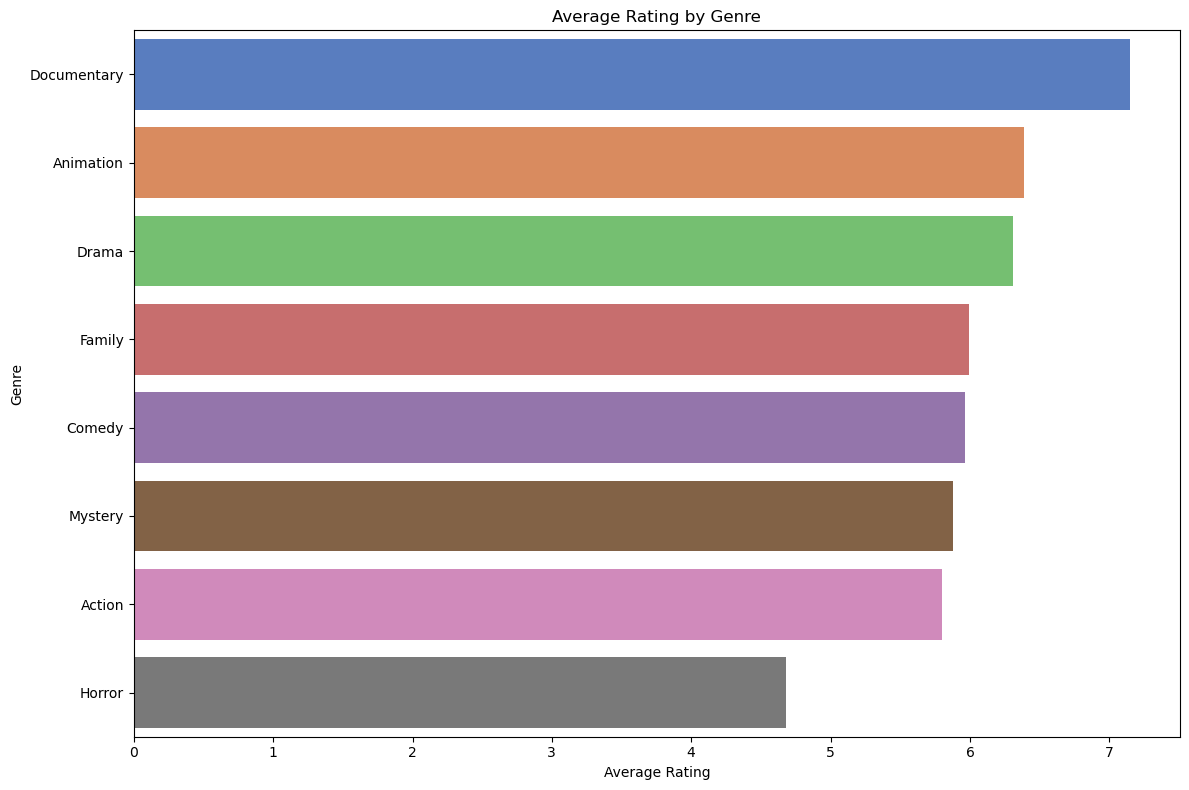

In [64]:
# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre', data=final_merged_df, palette='muted')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title(f'Average Rating by Genre')
plt.tight_layout()
plt.show();

- To ensure that we are able to give detailed analysis into each genre, we joined the aggregated DataFrame back to the Rotten Tomatoes DataFrame. 
    - The Rotten Tomatoes DataFrame contains the following:
        - Directors
        - Actors
        - Writers
        - Studio
        - Runtime
- Additionally, the top five genres from the aggregated DataFrame are:
    - Documentaries
    - Music
    - Biographies
    - Animated
    - Drama
- We want to give our client a choice between producing either a fictional or non-fictional movie. 
    - If we had selected only the top two genres to analyze, we would be limiting the scope of films our client could produce. 

# Data Analysis

## IMDB

In [65]:
# Split genres column by commas and get the first and rest parts
imdb_cast_info_df.loc[:, 'main_genre'] = imdb_cast_info_df['genres'].str.split(',').str[0]
imdb_cast_info_df.loc[:, 'sub_genre'] = imdb_cast_info_df['genres'].str.split(',', n=1).str[1]

### Directors

In [66]:
# Filter to see the directors only
imdb_director_df = imdb_cast_info_df[imdb_cast_info_df['cast_category'] == 'director']

#### Documentary

In [67]:
# Filter to see only Documentaries
documentary_director_films_df = imdb_director_df[imdb_director_df['main_genre'] == 'Documentary']

In [68]:
# Group by and aggregate to see which directors perform the best
documentary_director_films_df = documentary_director_films_df.groupby('cast_name').agg(
    average_rating=('averagerating', 'mean'),
    average_numvotes=('numvotes', 'mean'),
    movie_count=('movie_id', 'count')
).reset_index()

# Sort the DataFrame
documentary_director_films_df = documentary_director_films_df.sort_values(by='average_rating', ascending= False)

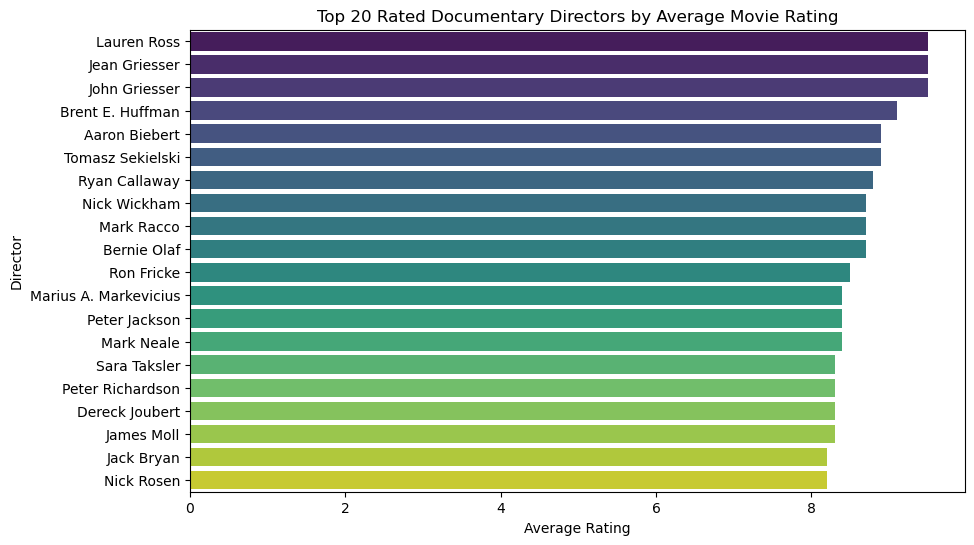

In [69]:
# Filter to see the top 20 directors by average rating
imdb_top_20_doc_directors = documentary_director_films_df.head(20)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x='average_rating', 
    y='cast_name', 
    data=imdb_top_20_doc_directors, 
    palette='viridis'
)
plt.xlabel('Average Rating')
plt.ylabel('Director')
plt.title('Top 20 Rated Documentary Directors by Average Movie Rating')
plt.show()

### Animated

In [70]:
# Filter to see only Music Films
animated_director_films_df = imdb_director_df[imdb_director_df['main_genre'] == 'Animation']

In [71]:
# Group by and aggregate to see which directors perform the best
animated_director_films_df = animated_director_films_df.groupby('cast_name').agg(
    average_rating=('averagerating', 'mean'),
    average_numvotes=('numvotes', 'mean'),
    movie_count=('movie_id', 'count')
).reset_index()

# Sort the DataFrame
animated_director_films_df = animated_director_films_df.sort_values(by='average_rating', ascending= False)

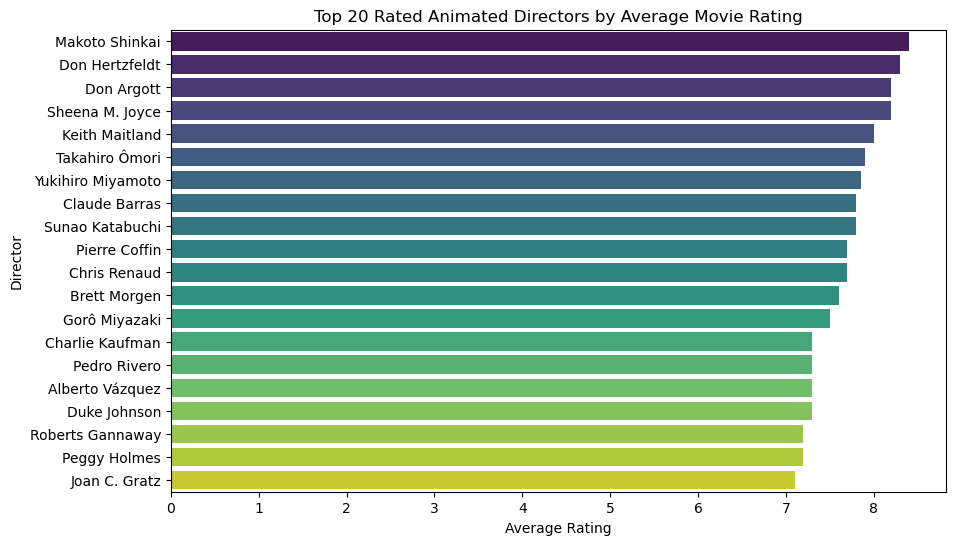

In [72]:
# Filter to see the top 20 directors by average rating
imdb_top_20_animated_directors = animated_director_films_df.head(20)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x='average_rating', 
    y='cast_name', 
    data=imdb_top_20_animated_directors, 
    palette='viridis'
)
plt.xlabel('Average Rating')
plt.ylabel('Director')
plt.title('Top 20 Rated Animated Directors by Average Movie Rating')
plt.show()

## Actors

Since there are no actors inside of Documentaries, we are only going to look at Animated Films

In [73]:
# Filter to see only actors and actresses
imdb_actor_actress_df = imdb_cast_info_df[imdb_cast_info_df['cast_category'].isin(['actor', 'actress'])]

# Filter to see only music films
imdb_actor_actress_df = imdb_actor_actress_df[imdb_actor_actress_df['main_genre'] == 'Animation']

In [74]:
# Group by and aggregate to see which directors perform the best
imdb_animated_actor_actress_df = imdb_actor_actress_df.groupby('cast_name').agg(
    average_rating=('averagerating', 'mean'),
    average_numvotes=('numvotes', 'mean'),
    movie_count=('movie_id', 'count')
).reset_index()

# Sort the DataFrame
imdb_animated_actor_actress_df = imdb_animated_actor_actress_df.sort_values(by='average_rating', ascending= False)

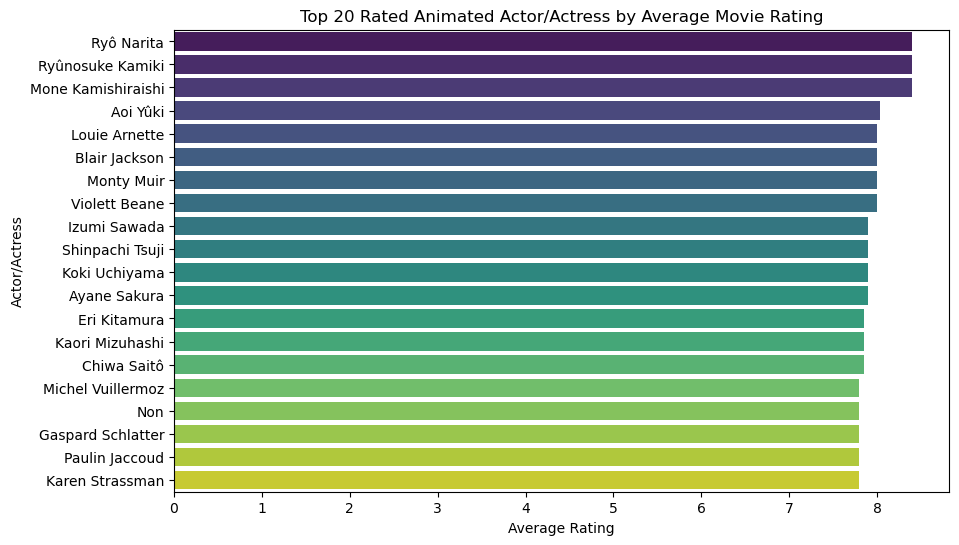

In [75]:
# Filter to see the top 20 actors and actresses by average rating
imdb_top_20_animated_actor_actress_df = imdb_animated_actor_actress_df.head(20)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(
    x='average_rating', 
    y='cast_name', 
    data=imdb_top_20_animated_actor_actress_df, 
    palette='viridis'
)
plt.xlabel('Average Rating')
plt.ylabel('Actor/Actress')
plt.title('Top 20 Rated Animated Actor/Actress by Average Movie Rating')
plt.show()

## TMDB

### Average rating vs. language
- Below we will be analyzing the average movie rating by language to see if there is any variance.
- We removed any languages that did not appear at least 50 times to remove any outliers.
- We found that Japanese, Korean, and Danish movies have the highest ratings, while english movies come in 8th place. 

Top 3 = Japanese, Korean, and Danish


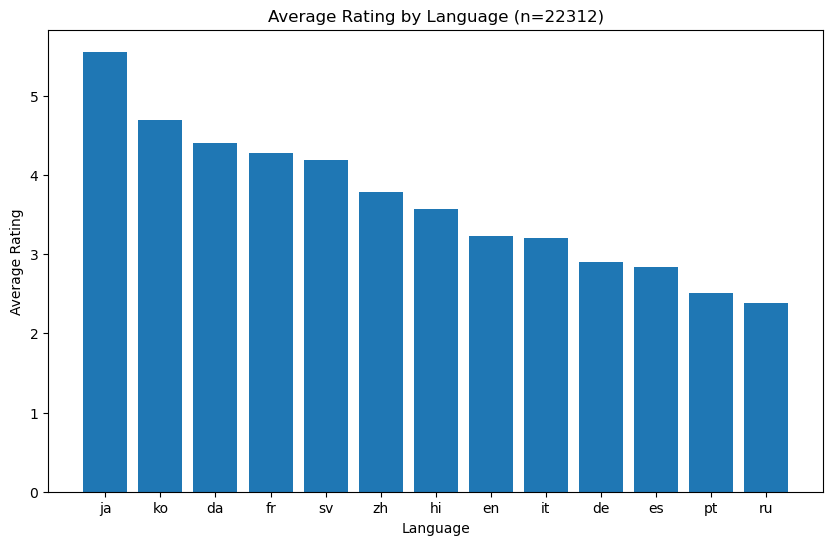

In [76]:
# Average rating by language shows and movies
tmdb_pop_lang = tmdb_df[['popularity',"original_language"]]

# Only keep ratings if the language appears more than 50 times
language_counts = tmdb_pop_lang['original_language'].value_counts()
filtered_languages = language_counts[language_counts > 50].index
tmdb_pop_lang = tmdb_pop_lang[tmdb_pop_lang['original_language'].isin(filtered_languages)]

n_count = len(tmdb_pop_lang)
tmdb_pop_lang = tmdb_pop_lang.groupby(['original_language'])['popularity'].mean().reset_index()
tmdb_pop_lang = tmdb_pop_lang.sort_values(by= 'popularity', ascending= False)
plt.figure(figsize=(10,6))
plt.title("Average Rating by Language"+" (n="+str(n_count)+")")
plt.xlabel('Language')
plt.ylabel('Average Rating')
plt.bar(tmdb_pop_lang['original_language'],tmdb_pop_lang['popularity'])
print("Top 3 = Japanese, Korean, and Danish")

We see that Japanese and Korean are the languages have the highest rated movies. 

We also see that in the IMDB DataFrame that for US released animated films the voice actors/actresses that have the highest rating tend to be either Japanese or Korean. This indicates that Japanese and Korean voice talent is highly esteemed in the industry, contributing to the success and high ratings of animated movies.

This underscores the impact and influence of Japanese and Korean cultures on global cinema, particularly in animated films. The high ratings of their movies and the prominent roles their voice actors play in successful US releases highlight the cross-cultural appreciation and demand for their artistic contributions.

## Rotten Tomatoes

In [77]:
def rt_get_top_20(dataframe, column, genre):
    """
    --
    Processes the given DataFrame to return the top 20 entries by average rating for a specified column.

    This function performs the following steps:
    1. Drops rows with NaN values in the specified column.
    2. Groups the DataFrame by the specified column and calculates the mean of 'rating_review' and count of entries.
    3. Sorts the DataFrame by the average rating in descending order.
    4. Returns the top 20 entries by average rating.
    --
    Input:
    dataframe : Pandas DataFrame 
    column (str): The column name to group by and analyze.
    --
    Output:
    top_20_dataframe: Pandas DataFrame
    """
    # Drop rows with NaNs
    new_dataframe = dataframe.dropna(subset=[column])
    
    # Filter rows to include only the specified genre
    new_dataframe = new_dataframe[new_dataframe['main_genre'] == genre]
    
    # Print length of DataFrame
    print(f"Number of rows in DataFrame: {len(new_dataframe)}")
    
    # Group and aggregate by specified column
    new_dataframe = new_dataframe.groupby(column).agg(
    average_rating = ('rating_review', 'mean')
    ,review_count = (column, 'size')
    ).reset_index()

    # Sort DataFrame
    new_dataframe = new_dataframe.sort_values(by='average_rating', ascending=False)
    
    # Filter to see the top 20 of the specified column by average rating
    top_20_dataframe = new_dataframe.head(20)
    
    return top_20_dataframe

In [78]:
def rt_plot_top_20_graph(original_dataframe, top_20_dataframe, column, genre):
    """
    --
    Plots a horizontal bar chart of the top 20 entries by average rating for a specified column.
    
    This function performs the following steps:
    1. Formats the column name for the plot labels.
    2. Creates a horizontal bar plot of average ratings using seaborn.
    --
    Input:
    dataframe : Pandas DataFrame
    column (str): The column name to be used for the y-axis labels in the plot.
    --
    Output:
    None
    """
    # Drop rows with NaNs
    new_dataframe = original_dataframe.dropna(subset=[column])
    
    # Format column title for the graph label
    split_column = column.split('_')
    plural_column = " ".join(split_column) + "s"
    formatted_column = plural_column.title()
    
    # Plotting
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(
        x='average_rating', 
        y=column, 
        data=top_20_dataframe, 
        palette='colorblind'
    )
    plt.xlabel('Average Rating')
    plt.ylabel(formatted_column)
    plt.title(f'Top 20 Rated {genre} {formatted_column} by Average Movie Rating (n={len(new_dataframe)})')

    # Adjust the layout to ensure y-axis labels are not cut off
    plt.tight_layout()

    # Save the figure with a white background
    plt.gcf().patch.set_facecolor('white')  # Set the facecolor of the figure
    #plt.savefig(f'{formatted_column}.png', transparent=False, facecolor='white')

    # Display the plot
    plt.show()

In [79]:
rt_combined_df['main_genre'].value_counts()

main_genre
Drama          2302
Comedy         2261
Action         1448
Animation       210
Documentary     160
Horror          142
Mystery          69
Family           34
Name: count, dtype: int64

### Directors

#### Documentary

Number of rows in DataFrame: 140


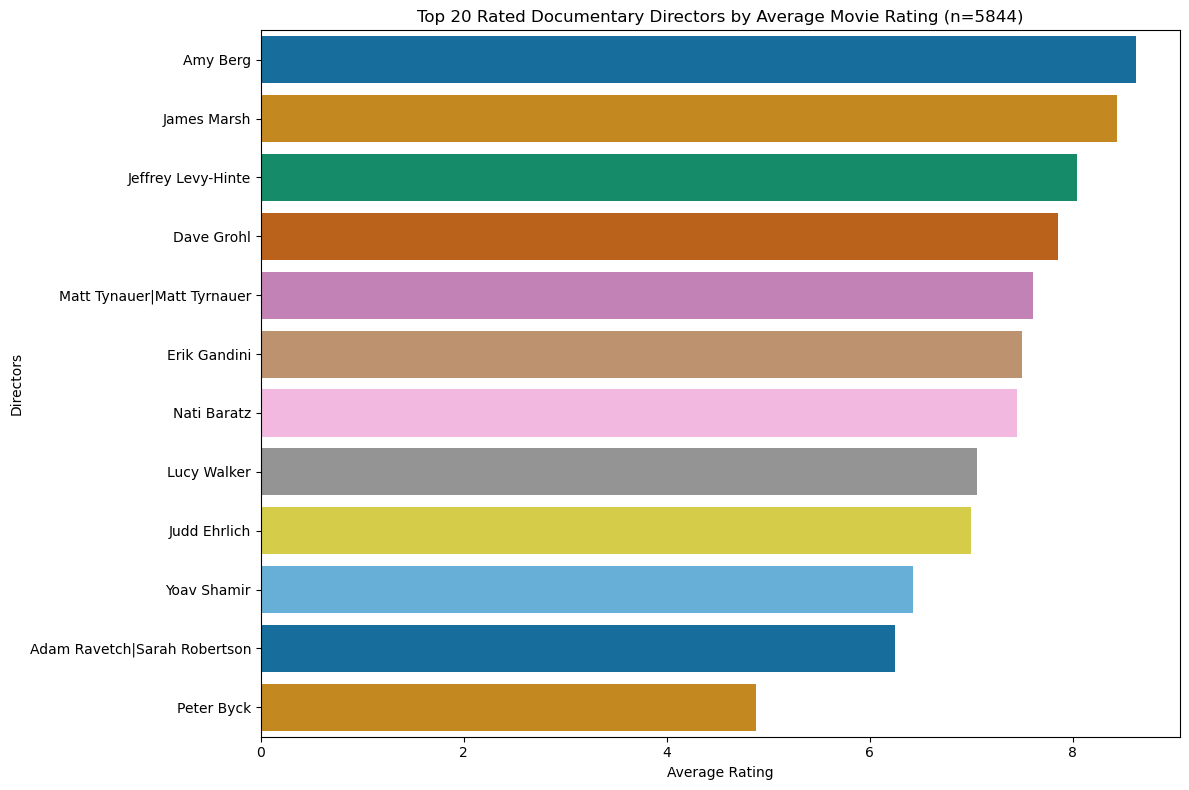

In [80]:
top_20_doc_director_df = rt_get_top_20(rt_combined_df, 'director', 'Documentary')
rt_plot_top_20_graph(rt_combined_df, top_20_doc_director_df, 'director', 'Documentary')

#### Animation

Number of rows in DataFrame: 180


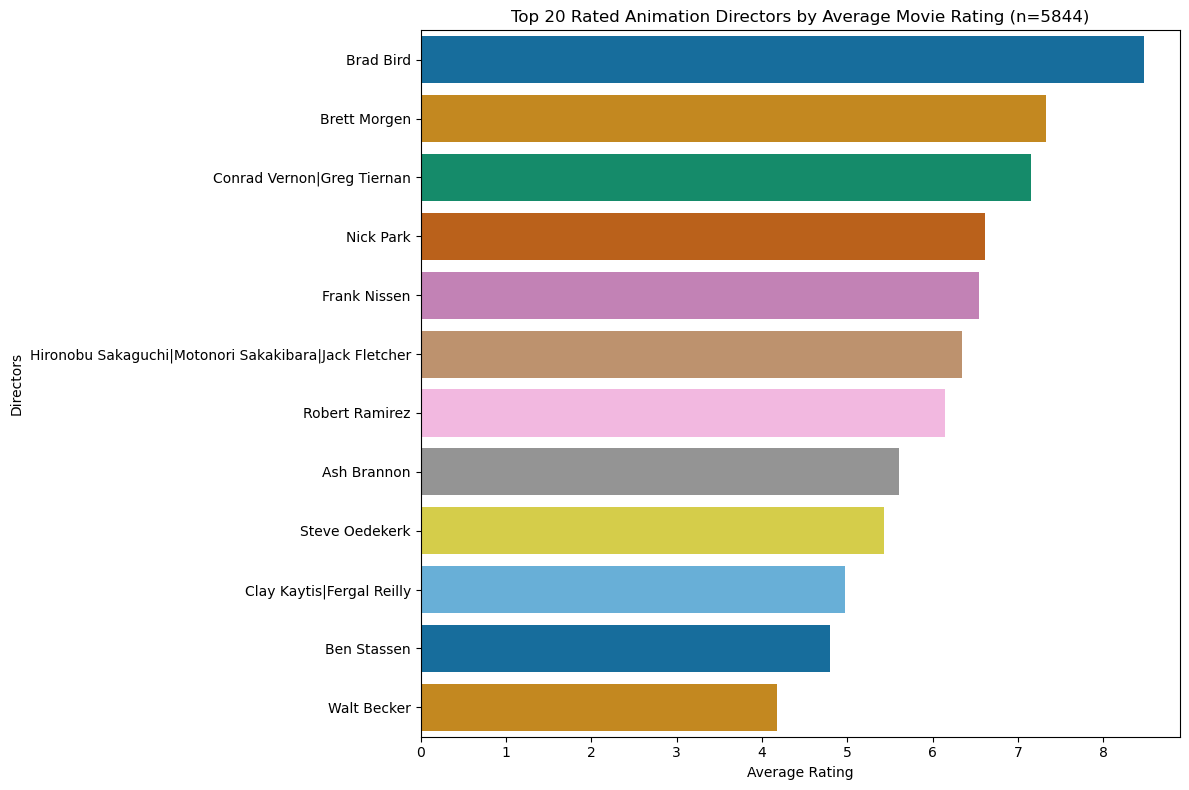

In [81]:
top_20_music_director_df = rt_get_top_20(rt_combined_df, 'director', 'Animation')
rt_plot_top_20_graph(rt_combined_df, top_20_music_director_df, 'director', 'Animation')

### Writers

#### Documentary

Number of rows in DataFrame: 80


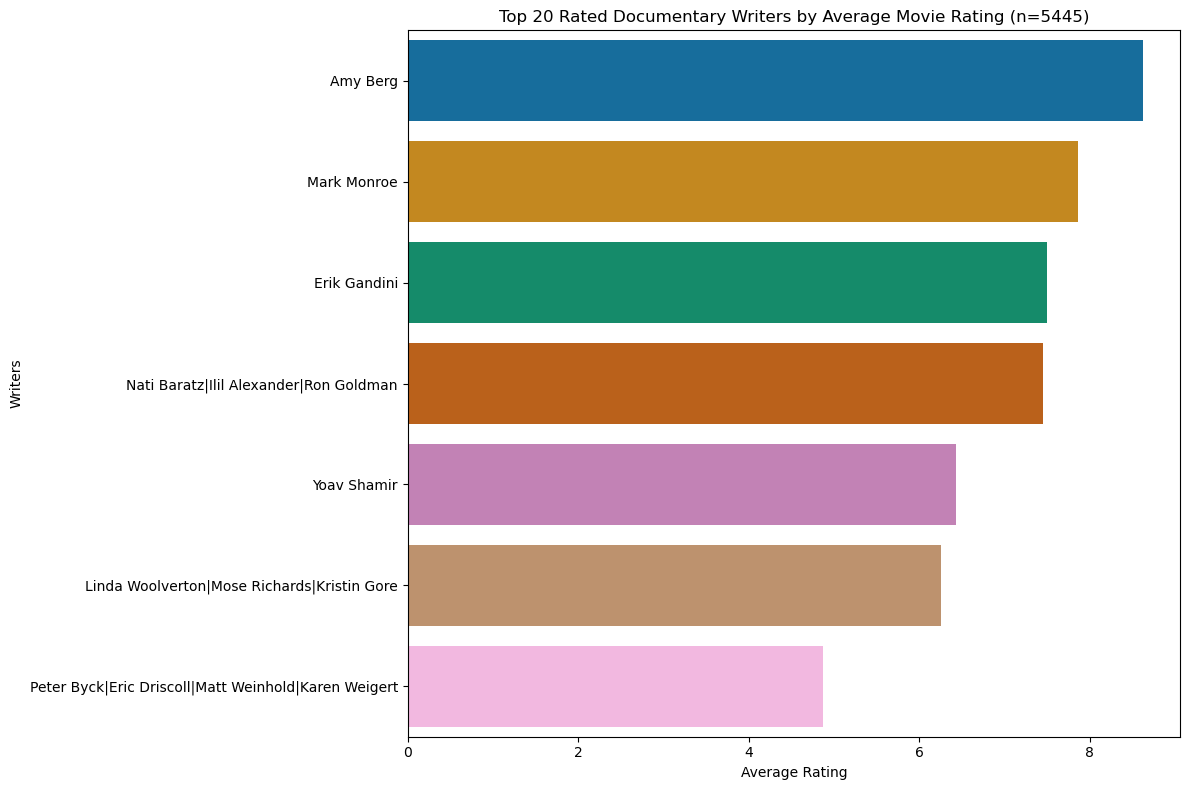

In [82]:
top_20_doc_writer_df = rt_get_top_20(rt_combined_df, 'writer', 'Documentary')
rt_plot_top_20_graph(rt_combined_df, top_20_doc_writer_df, 'writer', 'Documentary')

#### Animation

Number of rows in DataFrame: 200


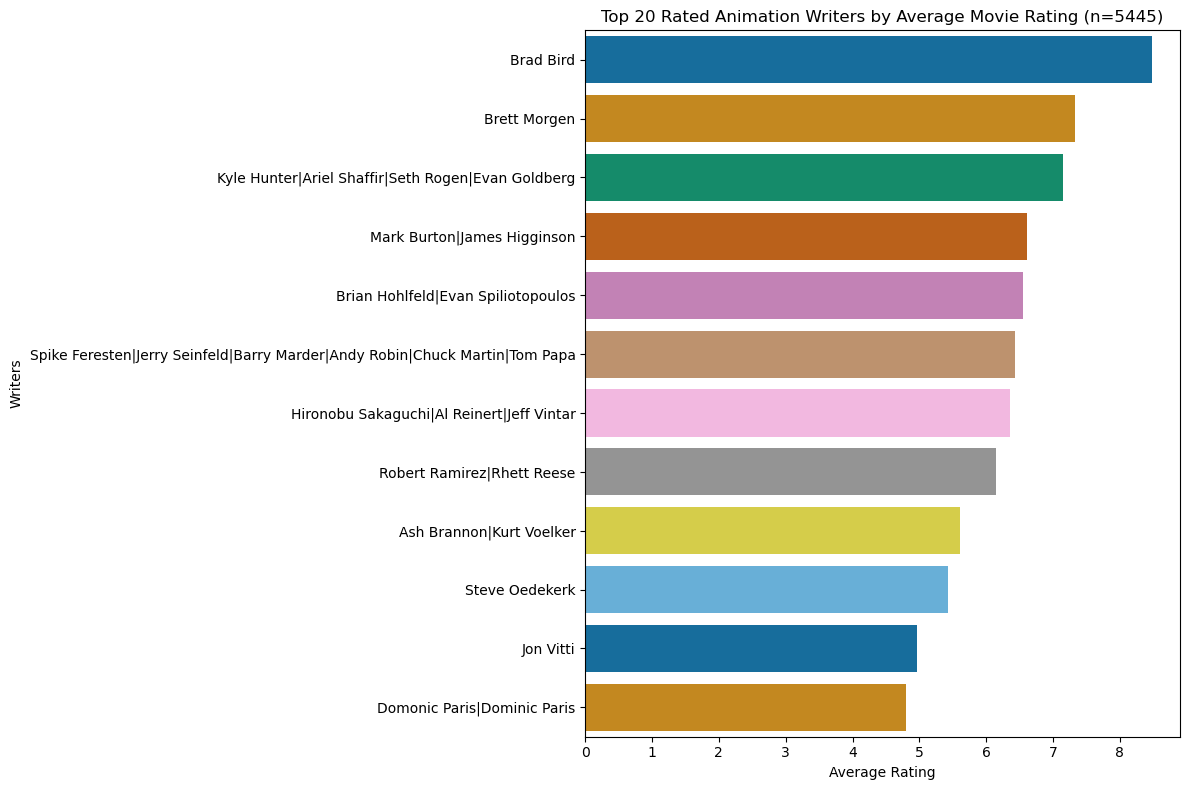

In [83]:
top_20_music_writer_df = rt_get_top_20(rt_combined_df, 'writer', 'Animation')
rt_plot_top_20_graph(rt_combined_df, top_20_music_writer_df, 'writer', 'Animation')

### Studio

#### Documentary

Number of rows in DataFrame: 138


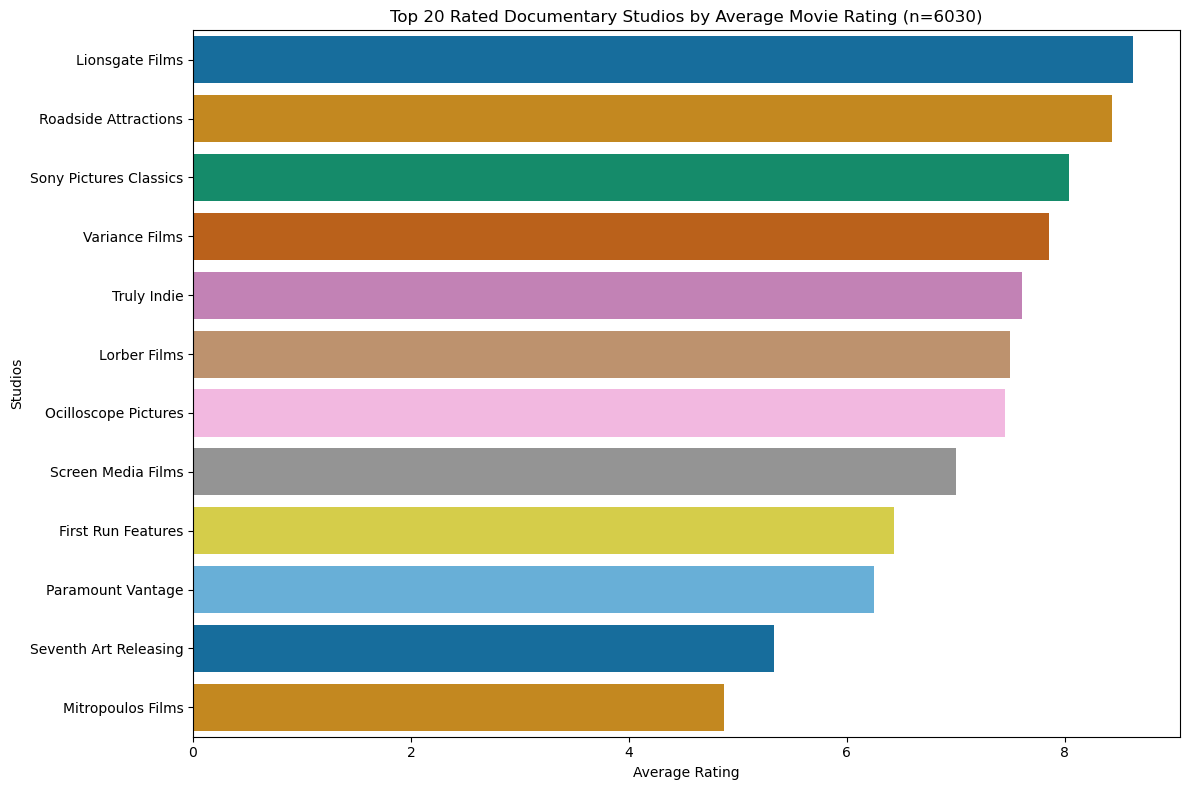

In [84]:
top_20_doc_studio_df = rt_get_top_20(rt_combined_df, 'studio', 'Documentary')
rt_plot_top_20_graph(rt_combined_df, top_20_doc_studio_df, 'studio', 'Documentary')

#### Animation

Number of rows in DataFrame: 200


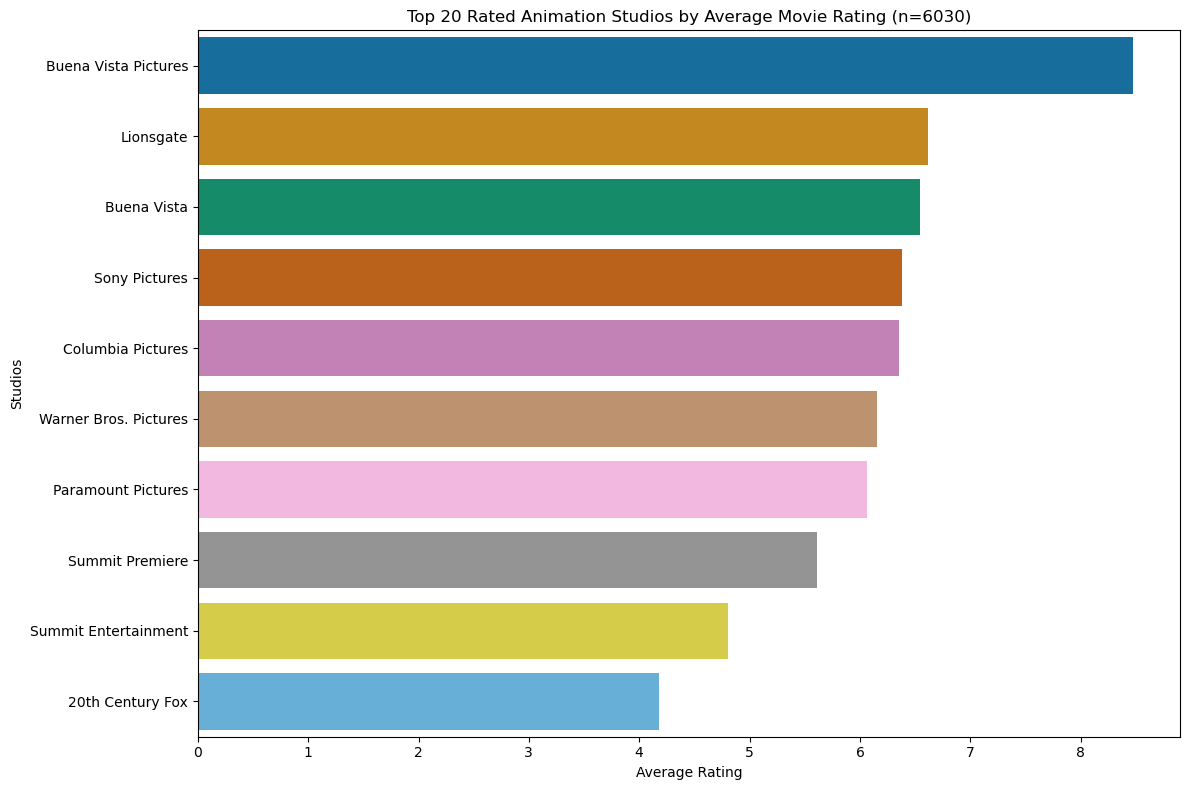

In [85]:
top_20_music_studio_df = rt_get_top_20(rt_combined_df, 'studio', 'Animation')
rt_plot_top_20_graph(rt_combined_df, top_20_music_studio_df, 'studio', 'Animation')

### Runtime

#### Documentary

Number of rows in DataFrame: 160


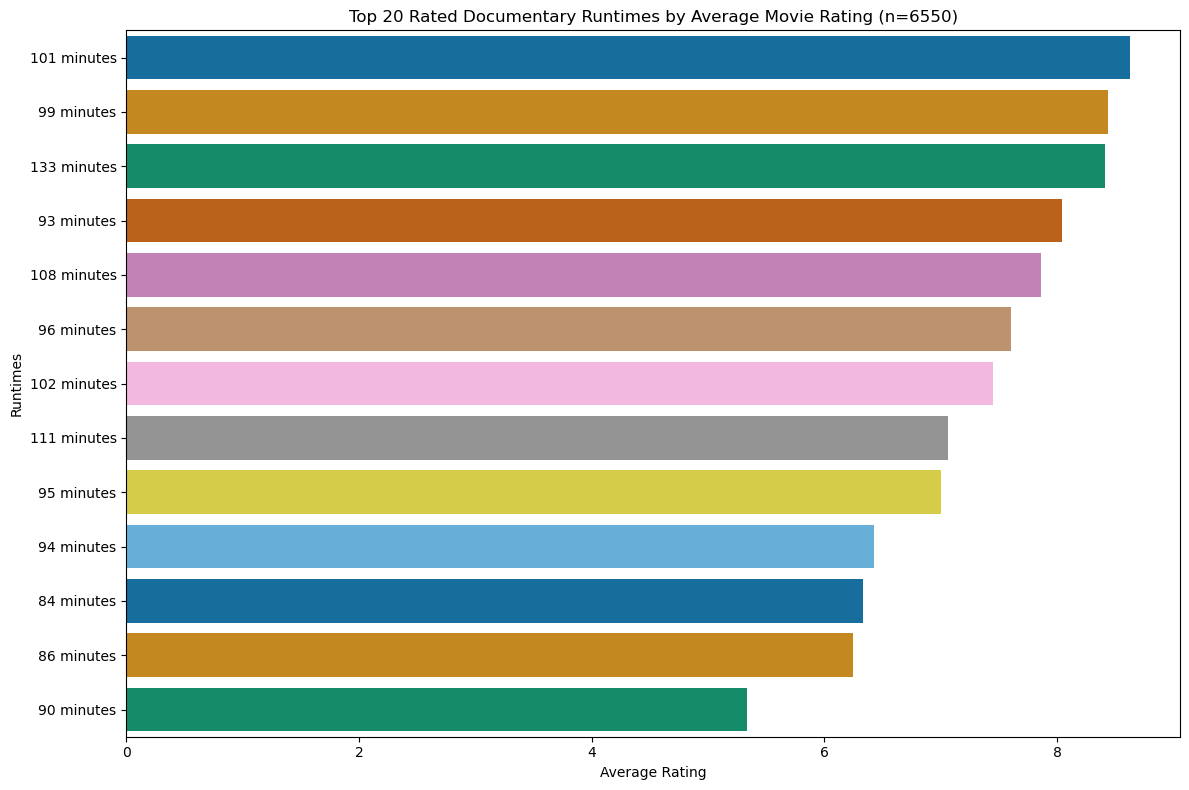

In [86]:
top_20_doc_runtime_df = rt_get_top_20(rt_combined_df, 'runtime', 'Documentary')
rt_plot_top_20_graph(rt_combined_df, top_20_doc_runtime_df, 'runtime', 'Documentary')

#### Animation

Number of rows in DataFrame: 210


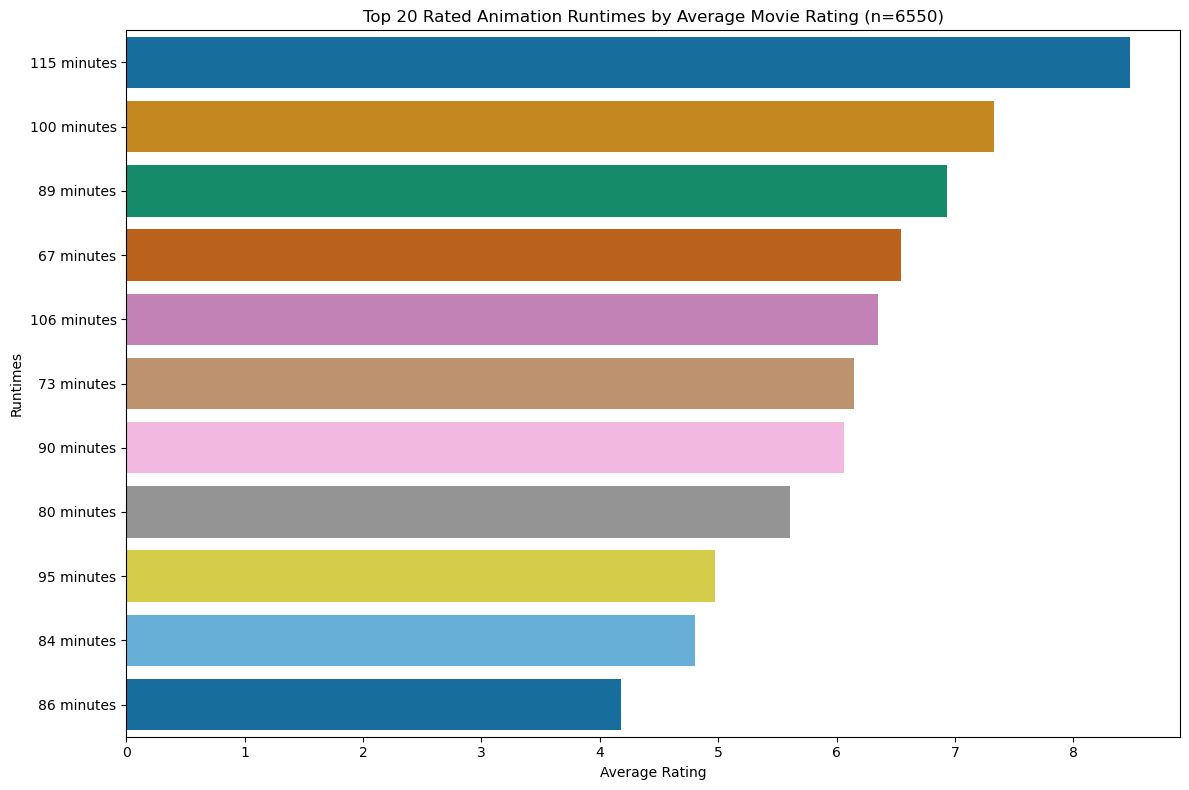

In [87]:
top_20_music_runtime_df = rt_get_top_20(rt_combined_df, 'runtime', 'Animation')
rt_plot_top_20_graph(rt_combined_df, top_20_music_runtime_df, 'runtime', 'Animation')

# Recommendations

### Profit vs. Release Day:
- 80.71% of all movie profits since 2000 went to movies that were released on a Friday.
- Movies that were released in May, June, July, November, and December saw significantly higher profits than the rest of the months. 
    + 65.3% of total profits went to movies that were released in these 5 months.
    + This is 41.76% of the year, so these 5 months combined see 23% more profit on average.

### Genre Type
- Domestic Fiction v Non-Fiction
    - Non-Fiction films have higher ratings than Fiction films. However, these are the two top level genres of film. The top performing genre in each category are listed below. 
    - Non-Fiction
        - Documentary films
    - Fiction
        - Animated Films

### Director
- Documentary
    - Amy Berg, James Marsh, Lauren Ross, Jean and John Griesser
- Animated
    - Brad Bird, Brett Morgan, Don Hertzfeldt and Don Argott
    
### Writer
- Documentary
    - Amy Berg and Marc Monroe
- Animated
    - Brad Bird and Brett Morgan
    
### Actors and Actresses
- Animated
    - Louie Arnette and Blair Jackson
    
### Studios
- Documentary
    - Lionsgate Films
- Animated
    - Buena Vista Pictures
    
### Runtime
- Documentary
    - 101 minutes
- Animated
    - 115 minutes